## Overview 
The dataset we chose contains car evaluation data derived from a hierarchical decision model developed initially for a demonstration of a decision making model and can be found at [[1]](#footnote1). The authors The dataset contains 6 attributes related to either price or technical characteristics. The 7th attribute represents the estimated class of the car and is based on all other attributes. The dataset consists of 1728 entries and is stripped of structural attributes, which means all attributes are directly related to the estimated car class attribute. There are also three intermediate attributes – PRICE, TECH and COMFORT – which are related to the 6 main attributes. 
## Use case
Choosing a vehicle to purchase can be a tedious process that involves hours of research, with studies showing American drivers spend an average of around 15 hours between realizing the need for a new car and making the purchase [[2]](#footnote2). 60% of this time is usually spent in online research of specifications and availability. Generally, although the most important attribute of a car is its ability to transport, the final decision is very often based on an amalgam of its price, safety and capacity. The main purpose for the collection of the dataset we chose was to “actively support the decision maker in the knowledge acquisition and evaluation stages of the decision making process” [[3]](#footnote3). 
## Prediction task
The dataset uses a simple hierarchical model to classify cars in one of 4 categories: Unacceptable (unacc), Acceptable (acc), Good (good), Very Good (vgood). The criteria tree is displayed below. The goal of our prediction task is to correctly identify the class associated with the car based on the 6 attributes that are used in the evaluation model, without specifying the model structure itself. 


<img src='tree.png' label="Criteria tree" height=500 width=500>
This could be useful in many different scenarios, such as helping manufacturers determine whether or not a new car would be well accepted by the market. Even after years of research and development, some car manufacturers suffer big financial losses due to lack of proper competitor analysis in the market and target audience expectations [[4]](#footnote4). Thus, for our evaluation criteria on this dataset, we aim to maximize the number of correctly predicted car classes in the range unacceptable and very good, as described above. The higher the percentage, the more reliable and valuable our algorithm will be to said manufacturers upon releasing a new vehicle to the market. The simplicity of the hierarchical decision model used in the training set could be a limitation to this performance and reliability, as we are only basing our results on the 6 attributes that are provided. A further drawback is the fact that all attributes are nominally assigned, which would fail to account for small differences of attribute values near the hard cutoff limits. 

 

### References
&nbsp;<a name="footnote1">1</a>: https://archive.ics.uci.edu/ml/datasets/Car+Evaluation <br>
&nbsp;<a name="footnote2">2</a>: https://www.elephant.com/blog/car-insurance/new-study-details-how-long-it-takes-before-car-shoppers-buy <br>
&nbsp;<a name="footnote3">3</a>: http://kt.ijs.si/MarkoBohanec/pub/Avignon88.pdf <br>
&nbsp;<a name="footnote4">4</a>: https://www.popularmechanics.com/cars/g1766/10-cars-that-deserved-to-fail/?slide=3 <br>






In [1]:
#Imports
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from scipy.special import expit


df = pd.read_csv('car.data')
buying_maint_map = {'vhigh':3,'high':2,'med':1,'low':0}
df['buy_price'] = df['buy_price'].map(buying_maint_map).astype(np.int)
df['maint_price'] = df['maint_price'].map(buying_maint_map).astype(np.int)
doors_map = {'2':0,'3':1,'4':2,'5more':3}
df['doors'] = df['doors'].map(doors_map).astype(np.int)
persons_map = {'2':0,'3':1,'4':2,'more':3}
df['persons'] = df['persons'].map(persons_map).astype(np.int)
trunk_map = {'small':0,'med':1,'big':2}
df['trunk_size'] = df['trunk_size'].map(trunk_map).astype(np.int)
safety_map = {'low':0,'med':1,'high':2}
df['safety'] = df['safety'].map(safety_map).astype(np.int)
class_map = {'unacc':0,'acc':1,'good':2,'vgood':3}
df['class'] = df['class'].map(class_map).astype(np.int)


feature_cols = ['buy_price','maint_price','doors','persons','trunk_size','safety']
class_cols = ['class']

#Make X a 2D numpy array
X = df[feature_cols].as_matrix()
#Make y a 1D numpy array
y = (df[class_cols]==0).astype(np.int).values.ravel()
y_not_binary = (df[class_cols]).astype(np.int).values.ravel()


## Data understanding
As can be seen in the pie chart below, 70% of the data we are using is in the unacceptable class. For our prediction task, this would mean that we are going to be much more accurate predicting cars in that specific class, as the training set is significantly larger. For our potential stakeholders, this would signify our ability to more accurately distinguish the cars that will probably not do very successfully on the market, than actually make projections related to actual potential market value and overall acceptability in the 4 classes. This makes our algorithm more applicable towards the possibility of a car being a failure in the market, which is what manufacturers would be most interested in. <br> The dataset contains no missing values. 

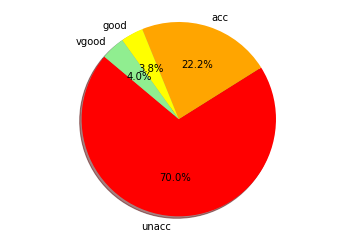

In [18]:
from collections import Counter
values = list(Counter(df['class']).values())
colors = ['red', 'orange', 'yellow', 'lightgreen']
plt.pie(values, labels=[k for k,v in class_map.items()], colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140)
 
plt.axis('equal')
plt.show()

In [3]:
#Taken from notebook 6
class BinaryLogisticRegression:
    def __init__(self, eta, iterations=20, C=0.001):
        self.eta = eta
        self.iters = iterations
        self.C = C
        # internally we will store the weights as self.w_ to keep with sklearn conventions
        
    def __str__(self):
        if(hasattr(self,'w_')):
            return 'Binary Logistic Regression Object with coefficients:\n'+ str(self.w_) # is we have trained the object
        else:
            return 'Untrained Binary Logistic Regression Object'
        
    # convenience, private:
    @staticmethod
    def _add_bias(X):
        return np.hstack((np.ones((X.shape[0],1)),X)) # add bias term
    
    @staticmethod
    def _sigmoid(theta):
        # increase stability, redefine sigmoid operation
        return expit(theta) #1/(1+np.exp(-theta))
    
    # vectorized gradient calculation with regularization using L2 Norm
    def _get_gradient(self,X,y):
        ydiff = y-self.predict_proba(X,add_bias=False).ravel() # get y difference
        gradient = np.mean(X * ydiff[:,np.newaxis], axis=0) # make ydiff a column vector and multiply through
        gradient = gradient.reshape(self.w_.shape)
        gradient[1:] += -2 * self.w_[1:] * self.C
        
        return gradient
    
    # public:
    def predict_proba(self,X,add_bias=True):
        # add bias term if requested
        Xb = self._add_bias(X) if add_bias else X
        return self._sigmoid(Xb @ self.w_) # return the probability y=1
    
    def predict(self,X):
        return (self.predict_proba(X)>0.5) #return the actual prediction
    
    
    def fit(self, X, y):
        Xb = self._add_bias(X) # add bias term
        num_samples, num_features = Xb.shape
        
        self.w_ = np.zeros((num_features,1)) # init weight vector to zeros
        
        # for as many as the max iterations
        for _ in range(self.iters):
            gradient = self._get_gradient(Xb,y)
            self.w_ += gradient*self.eta # multiply by learning rate 

In [3]:
%%time
class StochasticLogisticRegression(BinaryLogisticRegression):
    # stochastic gradient calculation 
    def _get_gradient(self,X,y):
        idx = int(np.random.rand()*len(y)) # grab random instance
        ydiff = y[idx]-self.predict_proba(X[idx],add_bias=False) # get y difference (now scalar)
        gradient = X[idx] * ydiff[:,np.newaxis] # make ydiff a column vector and multiply through
        
        gradient = gradient.reshape(self.w_.shape)
        gradient[1:] += -2 * self.w_[1:] * self.C
        
        return gradient
    
    
slr = StochasticLogisticRegression(0.1,1000, C=0.001) # take a lot more steps!!

slr.fit(X,y)

yhat = slr.predict(X)
print(slr)
print('Accuracy of: ',accuracy_score(y,yhat))

Binary Logistic Regression Object with coefficients:
[[ 2.81029423]
 [ 1.18040241]
 [ 0.85395683]
 [ 0.15779614]
 [-1.54962904]
 [-0.2911929 ]
 [-2.07777943]]
Accuracy of:  0.865162037037
Wall time: 68.8 ms


In [4]:
%%time
class NewtonLogisticRegression(BinaryLogisticRegression):
    def _hessian(self,X,y):
        g = self.predict_proba(X,add_bias=False).ravel()
        return X.T @ np.diag(g*(1-g)) @ X - 2 * self.C 
    def fit(self,X,y):
        Xb = self._add_bias(X) # add bias term
        num_samples, num_features = Xb.shape
        self.w_ = np.zeros((num_features,1)) # init weight vector to zeros
        # for as many as the max iterations
        for _ in range(self.iters):
            gradient = self._get_gradient(Xb,y)
            inv_hessian = np.linalg.inv(self._hessian(Xb,y))
            self.w_ +=  inv_hessian@gradient*self.eta # multiply by learning rate 
            
nlr = NewtonLogisticRegression(0.1,10, C=0.001) # take a lot more steps!!
nlr.fit(X,y)

yhat = nlr.predict(X)
print(nlr)
print('Accuracy of: ',accuracy_score(y,yhat))

Binary Logistic Regression Object with coefficients:
[[  1.37975242e-03]
 [  1.93921083e-04]
 [  1.72493226e-04]
 [ -5.89276349e-05]
 [ -3.67335919e-04]
 [ -1.64726414e-04]
 [ -6.00648741e-04]]
Accuracy of:  0.892361111111
Wall time: 186 ms


In [5]:
class MultiClassLogisticRegression:
    def __init__(self, eta, iterations=20, C=0.0001, optimize_func='steepest'):
        self.eta = eta
        self.iters = iterations
        self.C = C
        self.classifiers_ = []
        self.optimize_func = optimize_func
        # internally we will store the weights as self.w_ to keep with sklearn conventions
    
    def __str__(self):
        if(hasattr(self,'w_')):
            return 'MultiClass Logistic Regression Object with coefficients:\n'+ str(self.w_) # is we have trained the object
        else:
            return 'Untrained MultiClass Logistic Regression Object'
        
    def fit(self,X,y):
        num_samples, num_features = X.shape
        self.unique_ = np.sort(np.unique(y)) # get each unique class value
        num_unique_classes = len(self.unique_)
        self.classifiers_ = []
        for i,yval in enumerate(self.unique_): # for each unique value
            y_binary = (y==yval).astype(np.int) # create a binary problem
            # train the binary classifier for this class
            if self.optimize_func == 'stochastic':
                 hblr = StochasticLogisticRegression(self.eta,self.iters,self.C)
            elif self.optimize_func == 'steepest':
                hblr = BinaryLogisticRegression(self.eta,self.iters,self.C)
            elif self.optimize_func == 'newton':
                hblr = NewtonLogisticRegression(self.eta,self.iters,self.C)
            hblr.fit(X,y_binary)
            # add the trained classifier to the list
            self.classifiers_.append(hblr)
            
        # save all the weights into one matrix, separate column for each class
        self.w_ = np.hstack([x.w_ for x in self.classifiers_]).T
        
    def predict_proba(self,X):
        probs = []
        for hblr in self.classifiers_:
            probs.append(hblr.predict_proba(X).reshape((len(X),1))) # get probability for each classifier
        
        return np.hstack(probs) # make into single matrix
    
    def predict(self,X):
        return np.argmax(self.predict_proba(X),axis=1) # take argmax along row
    



In [7]:
%%time
lr = MultiClassLogisticRegression(0.1,iterations=0,C=0.00001,optimize_func='steepest')
lr.fit(X,y_not_binary)
print(lr)

yhat = lr.predict(X)
print('Accuracy of: ',accuracy_score(y_not_binary,yhat))

MultiClass Logistic Regression Object with coefficients:
[[ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]]
Accuracy of:  0.700231481481
Wall time: 15 ms


In [8]:
%%time
lr_st = MultiClassLogisticRegression(0.1,iterations=0,C=0.00001,optimize_func='stochastic')
lr_st.fit(X,y_not_binary)
print(lr_st)

yhat_st = lr_st.predict(X)
print('Accuracy of: ',accuracy_score(y_not_binary,yhat_st))

MultiClass Logistic Regression Object with coefficients:
[[ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]]
Accuracy of:  0.700231481481
Wall time: 9.52 ms


In [9]:
%%time
lr = MultiClassLogisticRegression(0.1,iterations=0,C=0.00001,optimize_func='newton')
lr.fit(X,y_not_binary)
print(lr)

yhat = lr.predict(X)
print('Accuracy of: ',accuracy_score(y_not_binary,yhat))

MultiClass Logistic Regression Object with coefficients:
[[ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]]
Accuracy of:  0.700231481481
Wall time: 8.52 ms
